![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, BaggingRegressor

from xgboost import XGBClassifier, XGBRegressor
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [57]:
# Función para calcular el RMSE
def calcula_rmse(y_pred, y_true):
    mse = np.mean((y_pred - y_true) ** 2)
    rmse = np.sqrt(mse)
    return rmse

# Definir la estructura del árbol de decisión
def build_tree(X_train, y_train, max_depth):
    # Definimos como condicion de parada ma la profundidad del arbol
    if max_depth == 0:
        return np.mean(y_train)
    
    # Seleccionar la mejor división
    best_feature = None
    best_value = None
    best_rmse = float('inf')

    for feature in X_train.columns:
        obs = X_train[feature]
        ValuesObs = obs.sort_values(ascending=True) #Ordenar ascedentemente
        ValuesObs = list(ValuesObs.drop_duplicates()) #Eliminar duplicados

         #Iterando por todos los puntos de corte de cada variable para obtener los MSE
        for i in range(0,len(ValuesObs)):
            cut = ValuesObs[i] #Valor del corte
            # Dividir el conjunto de entrenamiento en dos subconjuntos basandonos en la media de la variable
            left_indices = X_train[feature] <= cut
            right_indices = ~left_indices
            left_y = y_train[left_indices]
            right_y = y_train[right_indices]
            # Calcular el RMSE para esta división (lado derecho e izquierdo)
            left_rmse = calcula_rmse(np.full_like(left_y, np.mean(left_y)), left_y)
            right_rmse = calcula_rmse(np.full_like(right_y, np.mean(right_y)), right_y)
            total_rmse = (len(left_y) * left_rmse + len(right_y) * right_rmse) / len(y_train) #Promedio ponderado
            # Actualizar la mejor división si es necesario
            if total_rmse < best_rmse:
                best_rmse = total_rmse
                best_feature = feature
                best_value = X_train[feature].mean()

    # Construir los subárboles recursivamente
    left_indices = X_train[best_feature] <= best_value
    right_indices = ~left_indices
    left_tree = build_tree(X_train[left_indices], y_train[left_indices], max_depth - 1)
    right_tree = build_tree(X_train[right_indices], y_train[right_indices], max_depth - 1)
    return {'feature': best_feature, 'value': best_value, 'left': left_tree, 'right': right_tree}

# Realizar predicciones utilizando el árbol de decisión
def predict(tree, X_test):
    predicciones = []
    for _, instance in X_test.iterrows():
        node = tree
        while isinstance(node, dict):
            if instance[node['feature']] <= node['value']:
                node = node['left']
            else:
                node = node['right']
        predicciones.append(node)
    return np.array(predicciones)

# Construir el árbol de decisión

max_depth = 5  # Profundidad máxima del árbol
tree = build_tree(X_train, y_train, max_depth)
# Realizar predicciones en el conjunto de prueba
y_pred_arbol = predict(tree, X_test)
# Calcular el RMSE
rmse = calcula_rmse(y_pred_arbol, y_test)
print("RMSE del arbol:" + str(round(rmse,3)))
#Calcula MAE:
mae= np.mean(np.abs(y_pred_arbol-y_test))
print("MAE del arbol:" + str(round(mae,3)))

RMSE del arbol:1727.953
MAE del arbol:1297.867


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [15]:
#Obtención de las muestras
np.random.seed(123)
n_samples = X_train.shape[0] #Tamaño de cada muestra
n_B = 10 #Cantidad de muestras/arboles

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )] #Lista de muestras

RegTree = DecisionTreeRegressor(min_samples_split=20, random_state=0) #
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

for i, sample in enumerate(samples):
    X_train_bootstrap = X_train.iloc[sample,:]
    y_train_bootstrap = y_train.iloc[sample]
    RegTree.fit(X_train_bootstrap, y_train_bootstrap)
    y_pred.iloc[:,i] = RegTree.predict(X_test)
    
# Desempeño individual de cada árbol
print("Desempeño individual por arbol:")
for i in range(n_B):
    print('Árbol ', i, 'tiene un RMSE: ', np.sqrt(metrics.mean_squared_error(y_pred.iloc[:,i], y_test)))
    
for i in range(n_B):
    print('Árbol ', i, 'tiene un MAE: ', metrics.mean_absolute_error(y_pred.iloc[:,i], y_test))  
 
print("RMSE bagging:")
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred.mean(axis=1))))

print("MAE bagging:")
print(metrics.mean_absolute_error(y_test, y_pred.mean(axis=1)))


Desempeño individual por arbol:
Árbol  0 tiene un RMSE:  1836.2052179372517
Árbol  1 tiene un RMSE:  1855.398034931504
Árbol  2 tiene un RMSE:  1846.4539950262704
Árbol  3 tiene un RMSE:  1820.8657407188487
Árbol  4 tiene un RMSE:  1866.8603992461744
Árbol  5 tiene un RMSE:  1861.2412127665548
Árbol  6 tiene un RMSE:  1865.8647127387167
Árbol  7 tiene un RMSE:  1923.9698989024753
Árbol  8 tiene un RMSE:  1875.858352100732
Árbol  9 tiene un RMSE:  1887.2170564477447
Árbol  0 tiene un MAE:  1372.2128834087782
Árbol  1 tiene un MAE:  1366.998906588068
Árbol  2 tiene un MAE:  1373.5497324376258
Árbol  3 tiene un MAE:  1372.585099056888
Árbol  4 tiene un MAE:  1391.7002432057398
Árbol  5 tiene un MAE:  1384.4212317135518
Árbol  6 tiene un MAE:  1379.86089431924
Árbol  7 tiene un MAE:  1403.2699979667855
Árbol  8 tiene un MAE:  1388.2030215365612
Árbol  9 tiene un MAE:  1408.4550993008017
RMSE bagging:
1641.3206402923583
MAE bagging:
1216.884153064855


Se puede observar que el RMSE para cada uno de los arboles indivuales se encuentra en un rango entre 1820.8 y 1923.9 (para MAE: [1366.9, 1403.2]), mientras que el desempeño del modelo bagging es superior con un RMSE de 1641.3 (MAE 12.16.8). 
Esto comprueba que la introducción de aletoriedad a traves de la selección de muestras con bootstrap junto con la agregación de las predicciones de diferentes arboles incrementan la capacidad predictiva del modelo. Especificamnte esto estaría reduciendo la varianza total del modelo, generando una predicción más acertada.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [19]:
# Celda 3
RegTree = DecisionTreeRegressor()
BaggClf =BaggingRegressor(estimator= RegTree,
                           n_estimators=10, 
                           max_features=round(np.log(X_train.shape[1])), 
                           bootstrap=True, oob_score=True,
                           random_state=0
                           )

BaggClf.fit(X_train,list(y_train))
y_pred_bag = BaggClf.predict(X_test)

RMSEBagg = np.sqrt(np.average((y_pred_bag-y_test)**2))
print("El RMSE del modelo Bagging con 10 estimadores y número máximo de variables predictoras: log(n_features):" + str(RMSEBagg))

MAE_Bag = metrics.mean_absolute_error(y_pred_bag, y_test)
print('El MAE del modelo Bagging con 10 estimadores y número máximo de variables predictoras : log(n_features): ', MAE_Bag)

OOBErr = BaggClf.oob_score_
print("OOB score bagging con log(n_features):" + str(OOBErr))

El RMSE del modelo Bagging con 10 estimadores y número máximo de variables predictoras: log(n_features):2354.448602808742
El MAE del modelo Bagging con 10 estimadores y número máximo de variables predictoras : log(n_features):  1827.342848084451
OOB score bagging con log(n_features):0.4268957008631752


Para este caso el logaritmo del total de variables es equivalente a 2, por lo que cada arbol entrenado estaría considerando unicamente 2 variables. Como se ve esto afecta negativamente el modelo ya que tanto el RMSE (2354.4) como el MAE aumentan (1827.3).
Esta reducción en variables explicativas con un mismo numero bajo de arboles puede estar ocasionando que se pierda información para hacer las predicciones, resultando en un peor desempeño del modelo.
Se debe tener en cuenta que si se reduce el numero de variables, se debería aumentar la cantidad de arboles entrenados en el modelo, así se compensa la perdida de información por reducción de variables.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [20]:
# Celda 4
RFReg = RandomForestRegressor(bootstrap=True, oob_score=True,
                              random_state=0)
RFReg.fit(X_train,y_train)
y_pred_RF = RFReg.predict(X_test)

RMSErf = np.sqrt(np.average((y_pred_RF-y_test)**2))
print("RMSE Random Forest con parámetros sin calibrar:" + str(RMSErf))

MAE_RF = metrics.mean_absolute_error(y_pred_RF, y_test)
print("MAE Random Forest con parámetros sin calibrar:" + str(MAE_RF))

OOBRFErr = RFReg.oob_score_
print("OOB score Random Forest:" + str(OOBRFErr))

RMSE Random Forest con parámetros sin calibrar:1760.9789379390752
MAE Random Forest con parámetros sin calibrar:1310.1852141275215
OOB score Random Forest:0.8028330946186816


In [22]:
print("Parametros base del modelo en sklearn")
RFReg.get_params()

Parametros base del modelo en sklearn


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

Al ver el resultado de predicción del Random Forest sin calibrar encontramos que su desempeño (RMSE: 1760.9) es mas bajo que el del modelo de bagging con 10 predictores (RMSE: 1641.3). El modelo standar de sklearn utiliza 100 estimadores, con una sola variable y no limita la profundidad del arbol. Esto puede implicar perdida de información al utilizar una sola variable, así como casos de overfiting al no limitar la profundidad del arbol, resultando en un menor desempeño comparado al modelo de Bagging.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [23]:
# Celda 5
#Función de entrenamiento
def CalibraRF(X_train=X_train,y_train=y_train, y_test=y_test,
              max_features=X_train.shape[1], #Se deja max features inicial el total de predictores
              n_estimators=10, #Se inicializa en 10
              max_depth = None
              ):
    RFReg = RandomForestRegressor(bootstrap=True, oob_score=True,random_state=0, max_features=max_features, n_estimators=n_estimators, max_depth=max_depth )
    RFReg.fit(X_train,y_train)
    y_pred_RF = RFReg.predict(X_test)

    RMSERFT = np.sqrt(np.average((y_pred_RF-y_test)**2))
    return RMSERFT

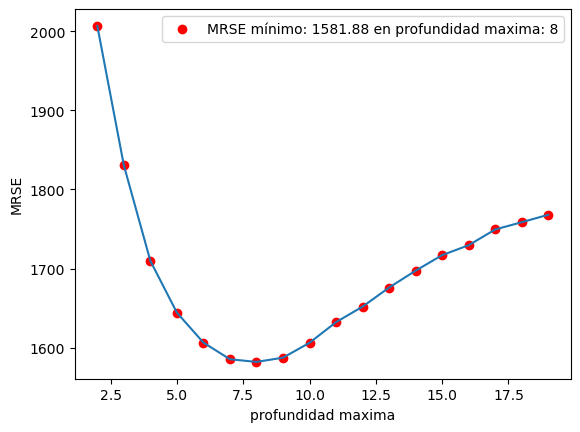

El valor mínimo de MRSE es: 1581.88 en profundidad maxima: 8


In [59]:
#Calibración max_depth
depth_cal = range(2,20,1)
depth_cal = list(depth_cal)
RMSE_result_RF = []

for i in depth_cal:
    RMSETest  = CalibraRF(max_depth=i)
    RMSE_result_RF.append(RMSETest)

plt.plot(depth_cal, RMSE_result_RF)
plt.xlabel('profundidad maxima')
plt.ylabel('MRSE')

min_MRSE = min(RMSE_result_RF)
indice_min_MRSE = RMSE_result_RF.index(min_MRSE)
n_estimators_min_MRSE = depth_cal[indice_min_MRSE]

plt.scatter(x=depth_cal, y=RMSE_result_RF, color='red', label=f'MRSE mínimo: {min_MRSE:.2f} en profundidad maxima: {n_estimators_min_MRSE}')
plt.legend()
plt.show()
print(f"El valor mínimo de MRSE es: {min_MRSE:.2f} en profundidad maxima: {n_estimators_min_MRSE}")

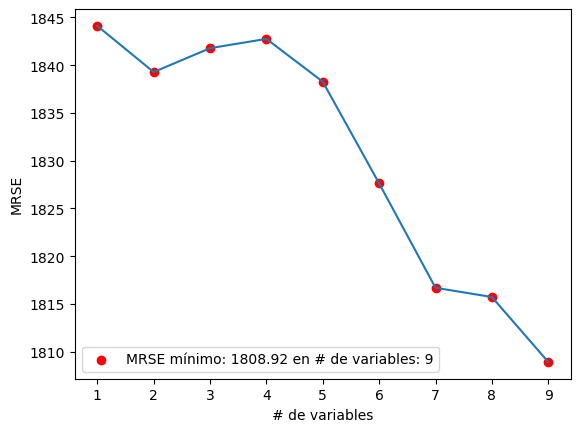

El valor mínimo de MRSE es: 1808.92 en # de variables: 9


In [60]:
#Calibración n_estimators
max_features_cal = range(1,X_train.shape[1]+1,1)
max_features_cal = list(max_features_cal)
RMSE_result_RFFeatures = []

for i in max_features_cal:
    RMSETest  = CalibraRF(max_features=i)
    RMSE_result_RFFeatures.append(RMSETest)

min_MRSE = min(RMSE_result_RFFeatures)
indice_min_MRSE = RMSE_result_RFFeatures.index(min_MRSE)
n_estimators_min_MRSE = max_features_cal[indice_min_MRSE]

plt.plot(max_features_cal, RMSE_result_RFFeatures)
plt.xlabel('# de variables')
plt.ylabel('MRSE')

plt.scatter(x=max_features_cal, y=RMSE_result_RFFeatures, color='red', label=f'MRSE mínimo: {min_MRSE:.2f} en # de variables: {n_estimators_min_MRSE}')
plt.legend()
plt.show()
print(f"El valor mínimo de MRSE es: {min_MRSE:.2f} en # de variables: {n_estimators_min_MRSE}")

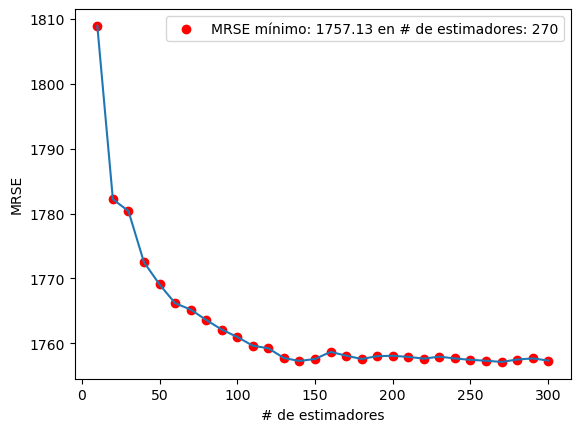

El valor mínimo de MRSE es: 1757.13 en # de estimadores: 270


In [61]:
#Calibración numero de estimadores
estimators_cal = range(10,310,10)
estimators_cal = list(estimators_cal)
RMSE_result_RF_mf = []

for i in estimators_cal:
    RMSETest  = CalibraRF(n_estimators=i)
    RMSE_result_RF_mf.append(RMSETest)

min_MRSE = min(RMSE_result_RF_mf)
indice_min_MRSE = RMSE_result_RF_mf.index(min_MRSE)
n_estimators_min_MRSE = estimators_cal[indice_min_MRSE]    

plt.plot(estimators_cal, RMSE_result_RF_mf)
plt.xlabel('# de estimadores')
plt.ylabel('MRSE')

plt.scatter(x=estimators_cal, y=RMSE_result_RF_mf, color='red', label=f'MRSE mínimo: {min_MRSE:.2f} en # de estimadores: {n_estimators_min_MRSE}')
plt.legend()
plt.show()
print(f"El valor mínimo de MRSE es: {min_MRSE:.2f} en # de estimadores: {n_estimators_min_MRSE}")


In [69]:
#Modelo optmo
RFRegOpt = RandomForestRegressor(max_depth = 8,
                              max_features= 9,
                              n_estimators = 270,                              
                              bootstrap=True, 
                              oob_score=True,
                              random_state=0)
RFRegOpt.fit(X_train,y_train)
y_pred_RF = RFRegOpt.predict(X_test)

RMSErfOpt_ = np.sqrt(np.average((y_pred_RF-y_test)**2))
print("RMSE Random Forest Optimo:" + str(RMSErfOpt_))

OOBRFErrOpt = RFRegOpt.oob_score_
print("OOB score Random Forest Optimo:" + str(OOBRFErrOpt))

RMSE Random Forest Optimo:1565.234986270169
OOB score Random Forest Optimo:0.8495741937767303


Al calibrar el parametro de profundidad máxima del arbol se observa un decesnso rapido de RMSE hasta el punto 8 despupes del cual comeinza  aumentar el RMSE. El valor mínimo que alcanza en este punto es de 1581.8, que supera el del valor del modelo estandar de sklearn (1760.9).

Por su parte al evaluar la cantidad de pedictores optima vemos que el modelo optimo utiliza todos las variables, punto en el cual alcanza un RMSE de 1808.9. Para este caso se ve que este parametro si bin reduce el error no lo hace en una magnitud tan considerable como la profundidad.

Al calibrar el parámetro de cantidad de estimadores (arboles) se ve que el modelo alcanza un punto de codo en a los 140 estimadores, luego oscila en un mismo nivel de RMSE para cada estaimador nuevo incluido, alcanzando un mínimo de eror en 270 con un RMSE 1757.1 (Inferior al minimo alcanzado calibrando el parámetro de profundiad). Si bien el minimo global se alcanza a los 270, para simplificar el problema computacional vemos valido evaluar un modelo optimo con 140 estimadores (casi la mitad) el cual arroja un RMSE de 1566.6 (muy similar al obtenido con 270 arboles).

En conclusión se ve que la precisión del modelo se ve afectada en mayor medida por la cantidad de estimadores (arboles) utilizada y la profundidad de cada arbol. Esto se refleja en que al alcanzar un punto optimo para cada uno el error del modelo disminuye considerablemente.

Finalmente al combinar los mejores paráetros de calibración en un modelo optimo, se ve que hasta el momento este tiene el mejor desempeño de todos: RMSE de 1565.2

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [62]:
# Celda 6
XGBrEG = XGBRegressor()
XGBrEG.fit(X_train, y_train)

y_pred_XGB= XGBrEG.predict(X_test)

RMSEXGBstandar = np.sqrt(np.average((y_pred_XGB-y_test)**2))
print("RMSE XGBoost Regresor:" + str(RMSEXGBstandar))


RMSE XGBoost Regresor:1605.2355199928948


De entrada el modelo base sin calibrar presenta un buen desempeño con un RMSE (1605.2) inferior al del modelo base de Random Forest (1760.9) y bagging manual con 10 estimadores (1641.3).

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

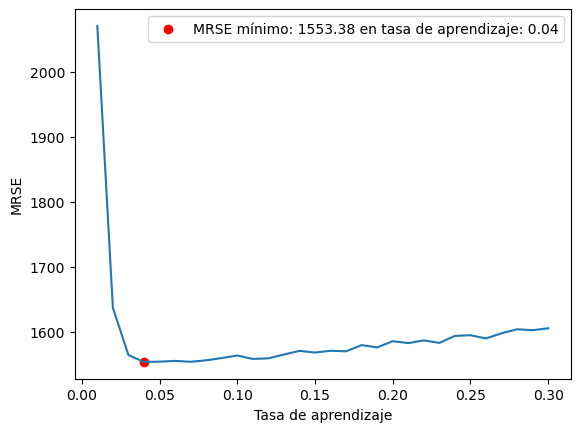

El valor mínimo de MRSE es: 1553.38 en tasa de aprendizaje : 0.04


In [53]:
#Calibración de tasa de aprendizaje

e_lr_XGB = np.arange(0.01, 0.31, 0.01)
MSRE_lr_XGB = []
MAE_lr_XGB = []

for rate in e_lr_XGB:
    
    clf_XGBc_lr = XGBRegressor(random_state = 42, learning_rate = rate, n_jobs = -1)
    
    clf_XGBc_lr.fit(X_train, y_train)
    y_pred_XGBc_lr = clf_XGBc_lr.predict(X_test)
    
    MSRE_lr_XGB.append(np.sqrt(metrics.mean_squared_error(y_pred_XGBc_lr, y_test)))
    MAE_lr_XGB.append(metrics.mean_absolute_error(y_pred_XGBc_lr, y_test))

#Gráfica
plt.plot(e_lr_XGB, MSRE_lr_XGB)
plt.xlabel('Tasa de aprendizaje')
plt.ylabel('MRSE')

min_MRSE = min(MSRE_lr_XGB)
indice_min_MRSE = MSRE_lr_XGB.index(min_MRSE)
n_estimators_min_MRSE = e_lr_XGB[indice_min_MRSE]

plt.scatter(n_estimators_min_MRSE, min_MRSE, color='red', label=f'MRSE mínimo: {min_MRSE:.2f} en tasa de aprendizaje: {n_estimators_min_MRSE}')
plt.legend()

plt.show()

print(f"El valor mínimo de MRSE es: {min_MRSE:.2f} en tasa de aprendizaje : {n_estimators_min_MRSE}")

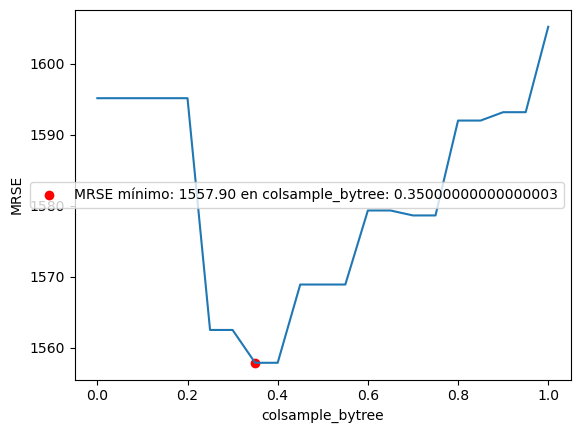

El valor mínimo de MRSE es: 1557.90 en colsample_bytree: 0.35000000000000003


In [54]:
#Cantidad aleatoria de muestras por arbol

e_cs_XGB = np.arange(0, 1.05, 0.05)
MSRE_cs_XGB = []
MAE_cs_XGB = []

for cs in e_cs_XGB:
    
    clf_XGBc_cs = XGBRegressor(random_state = 42, colsample_bytree = cs, n_jobs = -1)
    
    clf_XGBc_cs.fit(X_train, y_train)
    y_pred_XGBc_cs = clf_XGBc_cs.predict(X_test)
    
    MSRE_cs_XGB.append(np.sqrt(metrics.mean_squared_error(y_pred_XGBc_cs, y_test)))
    MAE_cs_XGB.append(metrics.mean_absolute_error(y_pred_XGBc_cs, y_test))

plt.plot(e_cs_XGB, MSRE_cs_XGB)
plt.xlabel('colsample_bytree')
plt.ylabel('MRSE')

min_MRSE = min(MSRE_cs_XGB)
indice_min_MRSE = MSRE_cs_XGB.index(min_MRSE)
n_estimators_min_MRSE = e_cs_XGB[indice_min_MRSE]

plt.scatter(n_estimators_min_MRSE, min_MRSE, color='red', label=f'MRSE mínimo: {min_MRSE:.2f} en colsample_bytree: {n_estimators_min_MRSE}')
plt.legend()

plt.show()

print(f"El valor mínimo de MRSE es: {min_MRSE:.2f} en colsample_bytree: {n_estimators_min_MRSE}")    

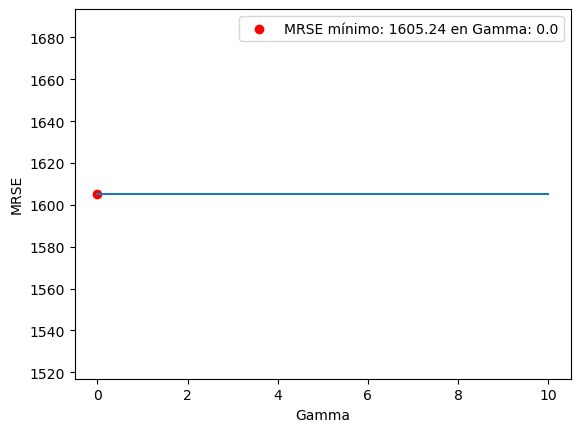

El valor mínimo de MRSE es: 1605.24 en Gamma: 0.0


In [55]:
#Calibración Gamma
e_g_XGB = np.arange(0, 10.5, 0.5)
MSRE_g_XGB = []
MAE_g_XGB = []

for g in e_g_XGB:
    
    clf_XGBc_g = XGBRegressor(random_state = 42, gamma = g, n_jobs = -1)
    
    clf_XGBc_g.fit(X_train, y_train)
    y_pred_XGBc_g = clf_XGBc_g.predict(X_test)
    
    MSRE_g_XGB.append(np.sqrt(metrics.mean_squared_error(y_pred_XGBc_g, y_test)))
    MAE_g_XGB.append(metrics.mean_absolute_error(y_pred_XGBc_g, y_test))

#Gráfica
plt.plot(e_g_XGB, MSRE_g_XGB)
plt.xlabel('Gamma')
plt.ylabel('MRSE')

min_MRSE = min(MSRE_g_XGB)
indice_min_MRSE = MSRE_g_XGB.index(min_MRSE)
n_estimators_min_MRSE = e_g_XGB[indice_min_MRSE]

plt.scatter(n_estimators_min_MRSE, min_MRSE, color='red', label=f'MRSE mínimo: {min_MRSE:.2f} en Gamma: {n_estimators_min_MRSE}')
plt.legend()

plt.show()

print(f"El valor mínimo de MRSE es: {min_MRSE:.2f} en Gamma: {n_estimators_min_MRSE}")    

In [56]:
#Modelo optimo
clf_XGBc_lr = XGBRegressor(random_state = 42, learning_rate = 0.04, n_jobs = -1, colsample_bytree_cal=0.35)
    
clf_XGBc_lr.fit(X_train, y_train)
y_pred_XGBc_lr = clf_XGBc_lr.predict(X_test)
    
MSRE_Opt_XGB = np.sqrt(metrics.mean_squared_error(y_pred_XGBc_lr, y_test))
print("RMSE del modelo XGBoost con parametros optimos:" + str(round(MSRE_Opt_XGB,3)))
MAE_Opt_XGB = metrics.mean_absolute_error(y_pred_XGBc_lr, y_test)
print("MAE del modelo XGBoost con parametros optimos:" + str(round(MAE_Opt_XGB,3)))

RMSE del modelo XGBoost con parametros optimos:1553.382
MAE del modelo XGBoost con parametros optimos:1140.23


Al calibrar el parametro de tasa de aprendizaje, se observa un descenso rapido del error hasta alcanzar un punto de codo minimo en 0.04 donde se obtiene un MRSE de 1553.3. Después de este punto el el error comienza a ascender nuevamente, por lo que es posible que despues de este punto una mayor tasa de aprendizaje este sobreajustando el modelo y esté aumentando la varianza.

Por su parte al calibrar el parámetro colsample_bytree que hace referencia a la proporción de caracteristicas muestreadas al azar para construir cada arbol del modelo, vemos que se alcanza un minimo en 0.35, lo que indica que se muestrean al azar 3 características por arbol. El resultado indica que después de este punto minimo el error vuelve a aumentar rapidamente, lo que sugiere que se ha introducido mucha precisión en el modelo y después de este punto el error por varianza resulta muy alto.

En cuanto al parámetro Gamma que controla la reducción mínima de perdida necesaria para realizar una división en un nodo del arbol, se ve que para este caso el modelo no se ve afectado por la selección de este parámetro mantenieindo un RMSE estable. Es posible que el beneficio de usar este parametro sea netamente computacional.

Como resultado final, al entrenar un modelo con los parametros optimos encontrados, vemos que tiene el mejor desempeño de todos los modelos de ensamblaje pues su RMSE llega a un valor de 1553.3 que es inferior al modelo optimo calibrado para Random Forest y Bagging.


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

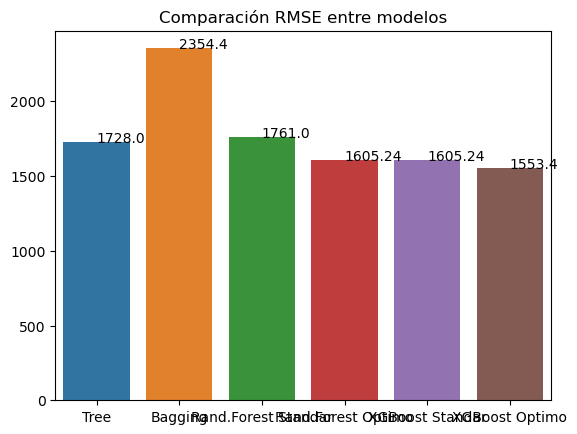

In [68]:
# Celda 8
RMSE_MODELOS = [round(rmse,1),round(RMSEBagg,1),round(RMSErf,1),round(RMSErfOpt_,2),round(RMSEXGBstandar,2),round(MSRE_Opt_XGB,1)]
nombre_MODELOS = ['Tree',
                  'Bagging', 
                  'Rand.Forest Standar',
                  'Rand.Forest Optimo',
                  'XGBoost Standar',
                  'XGBoost Optimo']


sns.barplot( x = nombre_MODELOS, y = RMSE_MODELOS)
plt.title("Comparación RMSE entre modelos")
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(nombre_MODELOS,RMSE_MODELOS,plt)
plt.show()


Al comparar el desempeño de todos los modelos utilizados se ve claramente como al agregarse complejidad ocurre na mejora en el desempeño. Se nota que el arbol de decisión tiene el poder predictivo más bajo, mientras que el modelo de XGBoost cuenta con el mejor desempeño.

Comparando los modelos agregdos, se puede ver que el modelo de bagging limitado al log(# features) con 10 arboles tiene un pesimo desempeño pues al limitarse tanto el numero de predictores como el numero de variables se sacrificó la precisión del modelo, resultando en el peor RMSE de los ensamblajes. 
Por su parte los modelo de random Forest presetan mejrias pues en su estructura, al incluir además del bootstraping, la selección aleatoria de variables permite una reducción en la varianza y una mejora compartiva de su desempeño. Se debe notar que si bien el modelo base mejoró, al calibrar los parámetros se da una reducción importante del error. 

Se destaca que el modelo XGBoost estándar presenta muy buenos resultados sin calibrar su parámetros (de hecho su resultado es casi el mismo que el del modelo de random forest calibrado), resultando en el mejor modelo al calibrar los parametros de tasa de aprendizaja y numero de columnas con selección aleatorioa. Estas ultimas dos carácterísticas unicas del modelo XGBoost demuestrn como al incorporar variabilidad y ajuste sobre los errores de aprendizaje, se pude reducir el error de predicción y tener una gran capacidad predictiva.